### Introduction
#### A brief analysis of the churn rate of the telecomunications **Telco Company** ([Link to data](https://www.kaggle.com/blastchar/telco-customer-churn)) using the **CRISP-DM** process: 
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Main objectives: 
- Better understand the CRISP-DM process, specifically focusing on:
    - Investigating the dataset & setting up business questions
    - Preparing & cleaning up data 
    - Modeling & evaluating the dataset
- Become familiarized with simple churn analysis

In [1]:
# Import modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model # LinearRegression
from sklearn import model_selection # train_test_split
from sklearn import metrics # r2_score, mean_squared_error
# Import required modules
from sklearn import preprocessing

from IPython.display import display
%matplotlib inline

cwd = os.getcwd()
ls = os.listdir()
print(cwd)
print(ls)

c:\Users\kwojn\OneDrive\Documents\DataScience\churn_analysis\churn_analysis
['.git', '.ipynb_checkpoints', 'churn_analysis - Copy.ipynb', 'churn_analysis.ipynb', 'data', 'img', 'README.md']


### Import data

In [2]:
# Import
df = pd.read_csv('.\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Dataset overview
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Rows & columns
rows = df.shape[0]
cols = df.shape[1]
print(f'Number of rows = {rows} & number of columns = {cols}')

Number of rows = 7043 & number of columns = 21


### Business questions to be analyzed in notebook
1. What are the total & monthly charges of current vs churned customers and is there a correlation between charges & churning? 
2. What is the tenure of current vs churned customers? How does tenure correlate with monthly / total charges (tornado plot)?
3. What services do people that are customers prefer vs people that churn? (nice tornado plot?)
4. Can we predict the churn rate based on the quantitative variables & how does the prediction improve when we add the categorical variables?

In [4]:
# Check dtypes of variables
df.dtypes.to_frame().T

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,object,object,int64,object,object,int64,object,object,object,object,...,object,object,object,object,object,object,object,float64,object,object


In [5]:
# Investigate total charges values
df["TotalCharges"].head()

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: object

In [53]:
# # --> Will give an ERROR!!!!
# Convert TotalCharges column to numeric variable 
pd.to_numeric(df['TotalCharges'], errors = 'raise')

ValueError: Unable to parse string " " at position 488

#### Clean up table

In [52]:
# Number of null or empty strings per variable
# Clean up data-set
# Nans
total_null_count = 0
index_null_values = []

#Check how many empty & blank strings in table
df_objects = df.select_dtypes(include=['object']).copy()
for col in df.columns:
    # print(col)
    if col in df_objects.columns:
        # Search for empty strings & blank with regex expression r"^\s*$" in categorical variables
        col_null_count = df[df[col].str.contains(r"^\s*$")==True][col].count()
        col_index_null_values = df[df[col].str.contains(r"^\s*$")==True].index.tolist()
        total_null_count += col_null_count
        index_null_values.extend(col_index_null_values)
        
    else: 
        # search for NaNs in numeric variabls
        col_null_count = df[col].isna().sum()
        col_index_null_values = df[np.isnan(df[col])].index.tolist()
        total_null_count += col_null_count
        index_null_values.extend(col_index_null_values)

print(f'Number of nan or empty values in table = {total_null_count}')
print(f'Nan or empty table rows: {index_null_values}')


Number of nan or empty values in table = 11
Nan or empty table rows: [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


In [8]:
# Convert TotalCharges to numeric
df_clean = df.drop(index_null_values, inplace=False).copy()
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors = 'raise')

# New shape of table
rows_clean = df_clean.shape[0]
cols_clean = df_clean.shape[1]

print(f'New number of rows = {rows_clean} vs old number of rows = {rows}')
print(f'New number of cols = {cols_clean} vs old number of cols = {cols}')

New number of rows = 7032 vs old number of rows = 7043
New number of cols = 21 vs old number of cols = 21


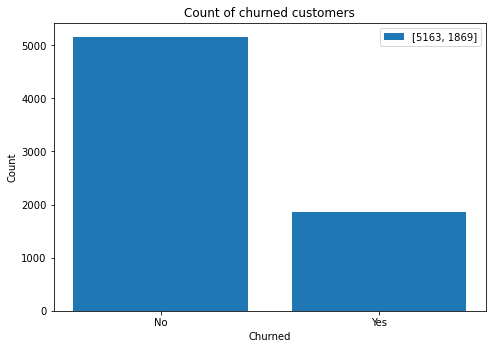

In [9]:
current_customer = df_clean[df_clean.Churn == 'No'] # Subset df_clean to only those that are currently customers
churned_customer = df_clean[df_clean.Churn == 'Yes'] # Subset df_clean to only those that have churned

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(pd.unique(df_clean["Churn"])),[current_customer.shape[0], churned_customer.shape[0]], label=[current_customer.shape[0], churned_customer.shape[0]])
ax.legend()
ax.set_xlabel('Churned'), ax.set_ylabel('Count'), ax.set_title('Count of churned customers')
plt.show()

# Analyze continuous data

In [57]:
list(df_clean.select_dtypes(exclude=['object']).columns)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

<AxesSubplot:>

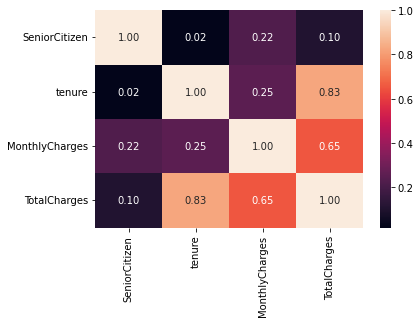

In [10]:
# Check heatmap of continous variables
sns.heatmap(df_clean.corr(), annot=True, fmt='.2f')

##### What are the statistics of monthly & total charges of customers vs people that churn?

### Total charges

In [11]:
total_charges_customer = df_clean[df_clean.Churn == 'No']['TotalCharges']
total_charges_churned = df_clean[df_clean.Churn == 'Yes']['TotalCharges']

print(f'Unique values in churned variable: {pd.unique(df_clean["Churn"])}')
print(f'Number of customers: {total_charges_customer.shape[0]}')
print(f'Number churned: {total_charges_churned.shape[0]}')

Unique values in churned variable: ['No' 'Yes']
Number of customers: 5163
Number churned: 1869


In [12]:
quantile_labels = total_charges_customer.describe()[-4:-1].index
quantiles_customer = total_charges_customer.describe()[-4:-1]
quantiles_churned = total_charges_churned.describe()[-4:-1]

# Create a table for quantiles & associated values
quantiles_customer_and_churned_total = pd.concat([quantiles_customer, quantiles_churned], axis=1)
ratio_total = quantiles_customer / quantiles_churned
quantiles_customer_and_churned_total = pd.concat([quantiles_customer_and_churned_total, ratio_total], axis=1)
quantiles_customer_and_churned_total.columns = ['Customers', 'Churned', 'Customer vs Churned ratio'] 
quantiles_customer_and_churned_total = quantiles_customer_and_churned_total.style.set_caption("Quantiles of total charges of currnet & churned customers")
quantiles_customer_and_churned_total 

,Customers,Churned,Customer vs Churned ratio
25%,577.825000,134.500000,4.296097
50%,1683.600000,703.550000,2.393007
75%,4264.125000,2331.300000,1.829076


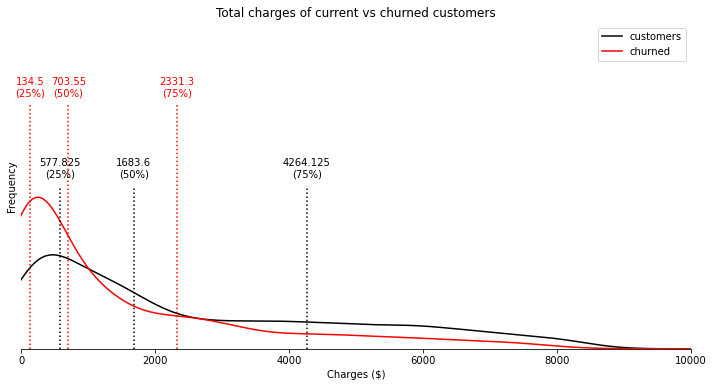

In [58]:
fig, ax = plt.subplots(figsize = (12,6))
# PLOTS
# KDE
total_charges_customer.plot(kind = "kde", color='black', label='customers', ax=ax)
total_charges_churned.plot(kind = "kde", color='red', label='churned', ax=ax)

# Plot percentiles
trans = ax.get_xaxis_transform()

for i in range(3):
    ax.axvline(quantiles_customer[i], color='black', ymax=0.5, alpha = 1, linestyle = ":")
    ax.axvline(total_charges_churned.describe()[-4:-1][i], color='red', ymax=0.75, alpha = 1, linestyle = ":")
    plt.text(quantiles_customer[i], .52, str(quantiles_customer[i]) + '\n(' + str(quantile_labels[i]) + ')', color = 'black', transform=trans, ha='center', va='bottom')
    plt.text(quantiles_churned[i], .77, str(total_charges_churned.describe()[-4:-1][i]) + '\n(' 
    + str(quantile_labels[i]) + ')', color = 'red', transform=trans, ha='center', va='bottom')

# X & Y labels & title
ax.set_xlabel("Charges ($)"), ax.set_ylabel('Frequency'), ax.set_title("Total charges of current vs churned customers")
# Configure plot
ax.set_xlim(0, 10000)
ax.set_ylim(0, 0.001)
# ax.tick_params(left = False, bottom = False)
ax.set_yticks([])
ax.spines[['left', 'right', 'top']].set_visible(False)
ax.legend()

> This result shows that the **current customers have higher total charges than the churned customers**, with the P50 being ~2 times larger for the current customers in comparison to the churned customers. It would be worthwhile to investigate what causes them to have higher total charges. 1st hypothesis that comes to mind is having a longer tenure. If so, it would be important to answer what makes them stay longer?

### Monthly charges

In [14]:
# filter data
# ALL customers - split data set into customers vs churned 
monthly_charges_customer = df_clean[df_clean.Churn == 'No']['MonthlyCharges']
monthly_charges_churned = df_clean[df_clean.Churn == 'Yes']['MonthlyCharges']

print(f'Number of customers: {monthly_charges_customer.shape[0]}')
print(f'Number churned customers: {monthly_charges_churned.shape[0]}')

# OLD cusomers - split data set into old customers vs old churned (without new customers where TotalCharges = 0)
monthly_charges_customer_old = df_clean[(df_clean.Churn == 'No') & (df_clean.TotalCharges != 0)]['MonthlyCharges'] 
monthly_charges_churned_old = df_clean[(df_clean.Churn == 'Yes') & (df_clean.TotalCharges != 0)]['MonthlyCharges']

# print(f'Number of old customers: {monthly_charges_customer_old.shape[0]}')
# print(f'Number of old churned customers: {monthly_charges_churned_old.shape[0]}')

print(f'Number of old customers (where total charges > 0) = total number of customers: {monthly_charges_customer_old.shape[0] == monthly_charges_customer.shape[0]}')

# TODO:
# --> plot histograms as line plot: https://towardsdatascience.com/take-your-histograms-to-the-next-level-using-matplotlib-5f093ad7b9d3
# --> compare average / p10 / p90 percentiles + skeweness
# --> What if we take away the customers that just joined (i.e. have no total charges)?
# --> Is there a clear difference in the monthly & total charges between people that stay vs people that churned? 

Number of customers: 5163
Number churned customers: 1869
Number of old customers (where total charges > 0) = total number of customers: True


In [15]:
quantile_labels = monthly_charges_customer.describe()[-4:-1].index
quantiles_customer_monthly = monthly_charges_customer.describe()[-4:-1]
quantiles_churned_monthly = monthly_charges_churned.describe()[-4:-1]

# Compare statistics of all vs old customers
ratio_all_monthly = quantiles_customer_monthly / quantiles_churned_monthly
quantiles_customer_and_churned_monthly = pd.concat([quantiles_customer_monthly, quantiles_churned_monthly, ratio_all_monthly], axis=1)
quantiles_customer_and_churned_monthly.columns = ['Customers', 'Churned', 'Customers vs churned ratio'] 
quantiles_customer_and_churned_monthly = quantiles_customer_and_churned_monthly.style.set_caption("Quantiles of monthly charges of current & churned customers")
quantiles_customer_and_churned_monthly 

,Customers,Churned,Customers vs churned ratio
25%,25.100000,56.150000,0.447017
50%,64.450000,79.650000,0.809165
75%,88.475000,94.200000,0.939225


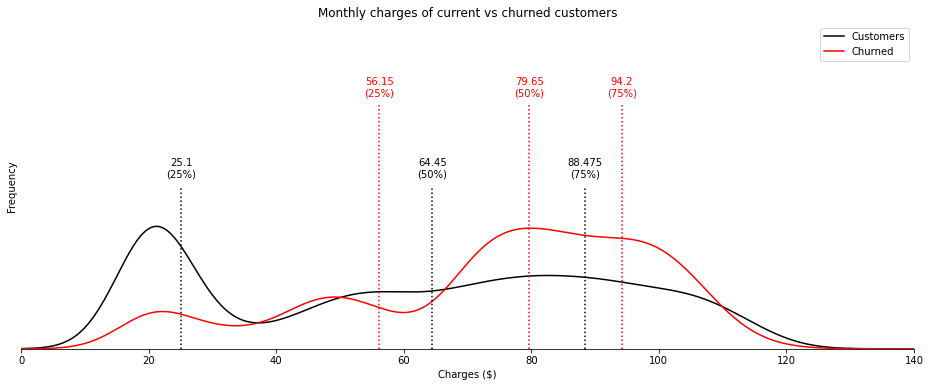

In [16]:
fig, ax = plt.subplots(figsize = (16,6))

# FIGURE 1
# PLOTS
# KDE
monthly_charges_customer.plot(kind = "kde", color='black', label='Customers', ax=ax)
monthly_charges_churned.plot(kind = "kde", color='red', label='Churned', ax=ax)

# Plot percentiles
# monthly_charges_customer.plot(kind = "kde", color='black', label='MonthlyCharges')
# monthly_charges_churned.plot(kind = "kde", color='red', label='MonthlyCharges')
trans = ax.get_xaxis_transform()

for i in range(3):
    ax.axvline(quantiles_customer_monthly[i], color='black', ymax=0.5, alpha = 1, linestyle = ":")
    ax.axvline(quantiles_churned_monthly[i], color='red', ymax=0.75, alpha = 1, linestyle = ":")
    plt.text(quantiles_customer_monthly[i], .52, str(quantiles_customer_monthly[i]) + '\n(' + str(quantile_labels[i]) + ')', color = 'black', transform=trans, ha='center', va='bottom')
    plt.text(quantiles_churned_monthly[i], .77, str(quantiles_churned_monthly[i]) + '\n(' + str(quantile_labels[i])+ ')', color = 'red', transform=trans, ha='center', va='bottom')

# X & Y labels & title
ax.set_xlabel("Charges ($)"), ax.set_ylabel('Frequency'), ax.set_title("Monthly charges of current vs churned customers")
# Configure plot
ax.set_xlim(0, 140), ax.set_ylim(0, 0.05)
# ax.tick_params(left = False, bottom = False)
ax.set_yticks([])
ax.spines[['left', 'right', 'top']].set_visible(False)
ax.legend()
# plt.show()

> This result shows that the **current customers have lower monthly charges than the churned customers**, with the P25/P50/P75 all being lower for the current customers in comparison to the churned customers. It is interesting that while the total charges for current customers are higher, the monthly charges for the current customers are lower. One reasonable explanation for this would be a longer tenure for current customers that have lower monthly charges. Moreover, after 60$ the churn rate seems to increase substantially. 

In [17]:
# Create series of tenure of current & churned customers
tenure_customer = df_clean[df_clean.Churn == 'No']['tenure']#.value_counts(normalize=True, bins = [0.001,1,2,3,4,5,10,15,20,30,40,50,60], sort=False)
tenure_churned = df_clean[df_clean.Churn == 'Yes']['tenure']#.value_counts(normalize=True, bins = [0.001,1,2,3,4,5,10,15,20,30,40,50,60], sort=False)


In [18]:
def merged_variable_statistics_current_vs_churned(current, churned, columns = ['Current', 'Churned', 'Current vs churned ratio'], title='Title'):
    #Get quantiles
    quantile_labels = current.describe()[-4:-1].index
    quantiles_current = current.describe()[-4:-1]
    quantiles_churned = churned.describe()[-4:-1]
    # Compare statistics of all vs old customers
    ratio = quantiles_current / quantiles_churned
    quantile_values = pd.concat([quantiles_current, quantiles_churned, ratio], axis=1)
    quantile_values.columns = columns
    quantiles_current_and_churned = quantile_values.style.set_caption(title)
    display(quantiles_current_and_churned)
    return quantile_labels, quantile_values

In [19]:
quantile_labels, quantile_values = merged_variable_statistics_current_vs_churned(tenure_customer, tenure_churned, title='Quantiles of tenure of current & churned customers')

,Current,Churned,Current vs churned ratio
25%,15.000000,2.000000,7.500000
50%,38.000000,10.000000,3.800000
75%,61.000000,29.000000,2.103448


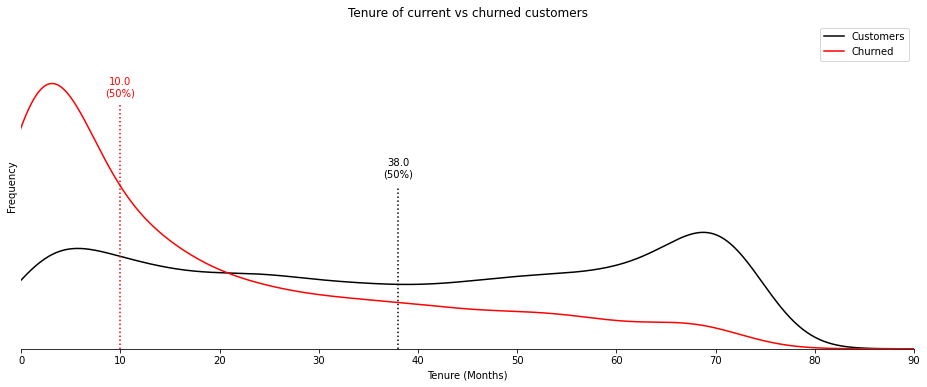

In [20]:
fig, ax = plt.subplots(figsize = (16,6))
# FIGURE 1
# PLOTS
# KDE
tenure_customer.plot(kind = "kde", color='black', label='Customers', ax=ax)
tenure_churned.plot(kind = "kde", color='red', label='Churned', ax=ax)

# # Plot percentiles
trans = ax.get_xaxis_transform()
ax.axvline(quantile_values['Current']['50%'], color='black', ymax=0.5, alpha = 1, linestyle = ":")
ax.axvline(quantile_values['Churned']['50%'], color='red', ymax=0.75, alpha = 1, linestyle = ":")
plt.text(quantile_values['Current']['50%'], .52, str(quantile_values['Current']['50%']) +  '\n(' + str(quantile_labels[1]) + ')', color = 'black', transform=trans, ha='center', va='bottom')
plt.text(quantile_values['Churned']['50%'], .77, str(quantile_values['Churned']['50%']) +  '\n(' + str(quantile_labels[1]) + ')', color = 'red', transform=trans, ha='center', va='bottom')

# X & Y labels & title
ax.set_xlabel("Tenure (Months)"), ax.set_ylabel('Frequency'), ax.set_title("Tenure of current vs churned customers")
# Configure plot
ax.set_xlim(0, 90), ax.set_ylim(0, 0.05)
ax.set_yticks([])
ax.spines[['left', 'right', 'top']].set_visible(False)
ax.legend()

> This result shows that the **current customers have longer tenure than the churned customers**, with the P25/P50/P75 all being higher for the current customers in comparison to the churned customers. This is as expected, since the current customers had larger total charges, while maintaining lower monthly charges. 

# Analyze categorical data

In [21]:
print("Categorical data: ", list(df_clean.select_dtypes(include=['object']).columns))


Categorical data:  ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [22]:
categories = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
'Contract', 'PaperlessBilling', 'PaymentMethod']

In [23]:
print("Categories")
for col in df_clean.columns:
       if col in categories:
              print(col, '\t', df_clean[col].unique(), '\t length: ', len(df_clean[col].unique()))

Categories
gender 	 ['Female' 'Male'] 	 length:  2
Partner 	 ['Yes' 'No'] 	 length:  2
Dependents 	 ['No' 'Yes'] 	 length:  2
PhoneService 	 ['No' 'Yes'] 	 length:  2
MultipleLines 	 ['No phone service' 'No' 'Yes'] 	 length:  3
InternetService 	 ['DSL' 'Fiber optic' 'No'] 	 length:  3
OnlineSecurity 	 ['No' 'Yes' 'No internet service'] 	 length:  3
OnlineBackup 	 ['Yes' 'No' 'No internet service'] 	 length:  3
DeviceProtection 	 ['No' 'Yes' 'No internet service'] 	 length:  3
TechSupport 	 ['No' 'Yes' 'No internet service'] 	 length:  3
StreamingTV 	 ['No' 'Yes' 'No internet service'] 	 length:  3
StreamingMovies 	 ['No' 'Yes' 'No internet service'] 	 length:  3
Contract 	 ['Month-to-month' 'One year' 'Two year'] 	 length:  3
PaperlessBilling 	 ['Yes' 'No'] 	 length:  2
PaymentMethod 	 ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 	 length:  4


In [24]:
# floor()
int(np.ceil(len(categories) / 3))


5

In [25]:
def categorical_analysis_plots(df_clean, categories):

    fig, axes = plt.subplots(int(np.ceil(len(categories) / 3)), 3, figsize=(16, 16))
    fig.suptitle('Categorical data')
    i_idx = 0
    j_idx = 0

    for cat in categories:
        sns.countplot(ax = axes[i_idx, j_idx], x=cat, hue="Churn", data=df_clean).set(title=f'{cat}')
        if len(df_clean[cat].unique()) > 3:
            axes[i_idx, j_idx].set_xticklabels(axes[i_idx, j_idx].get_xticklabels(), rotation=40, ha="right")

        j_idx += 1
        if j_idx > 2:
            j_idx = 0
            i_idx += 1
    plt.tight_layout()

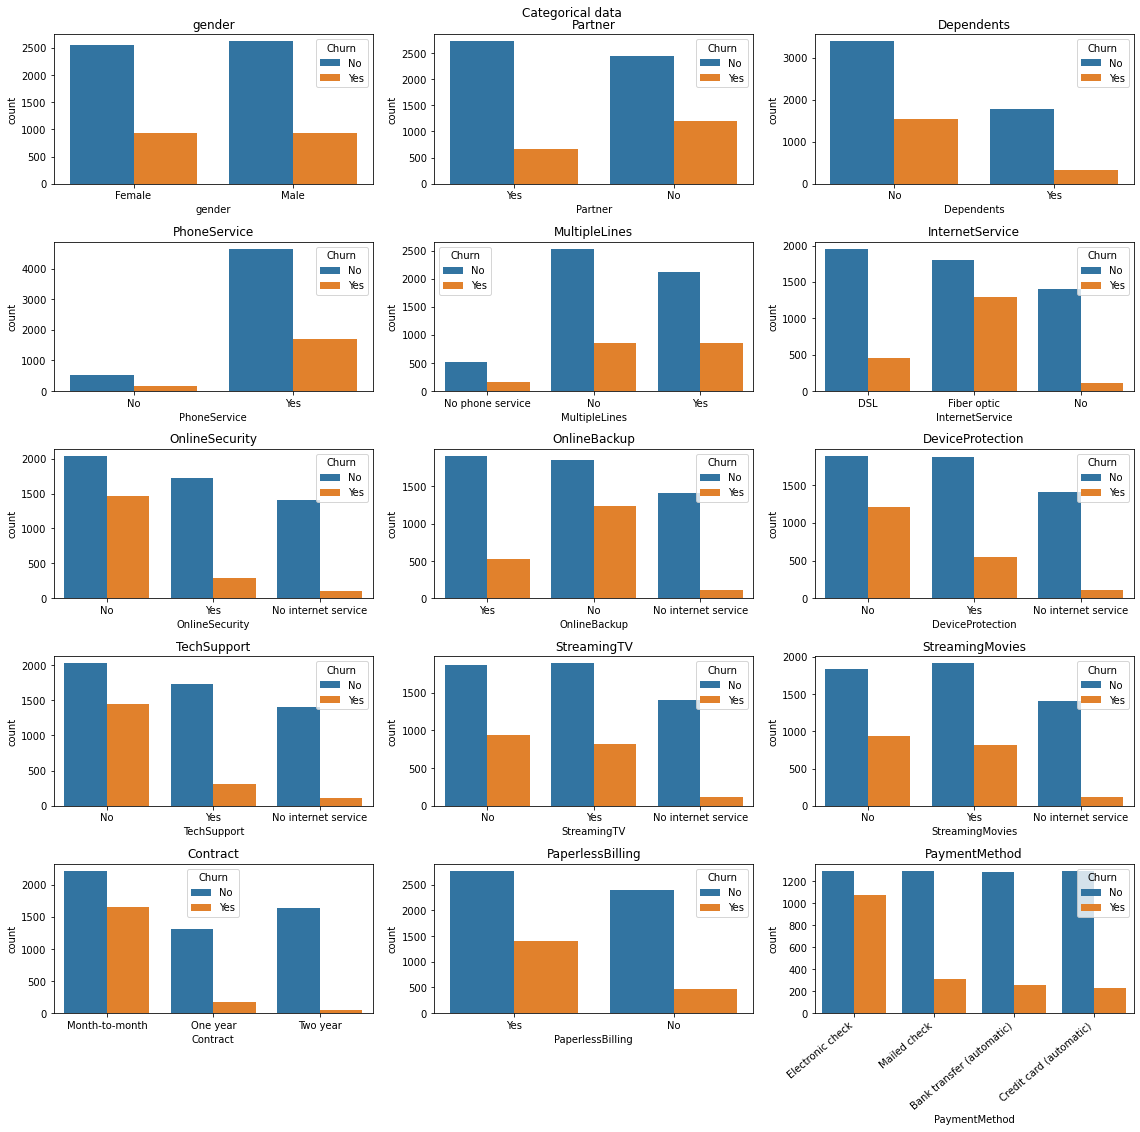

In [26]:
categorical_analysis_plots(df_clean, categories)

In [27]:
from collections import defaultdict

# Function taken from UDACITY data science class
def total_count(df, col1, col2, look_for):
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df


possible_vals = list(df_clean['Contract'].unique())

def clean_and_plot(df, title='Method of Educating Suggested', plot=True):
    # Plot bar graph of different contracts (for current & churned customers)
    x = df['Contract'].value_counts().reset_index()
    x.rename(columns={'index': 'contract', 'Contract': 'count'}, inplace=True)
    x_df = total_count(x, 'contract', 'count', possible_vals)

    x_df.set_index('contract', inplace=True)
    if plot:
        (x_df/x_df.sum()).plot(kind='bar', legend=None)
        plt.title('Contract type')
        plt.show()
    props_x_df = x_df/x_df.sum()
    return props_x_df

In [28]:
current_customer_perc = clean_and_plot(current_customer, 'Customer', plot=False)
churned_customer_perc = clean_and_plot(churned_customer, 'Churned', plot=False)

comp_df = pd.merge(current_customer_perc, churned_customer_perc, left_index=True, right_index=True)
comp_df.columns = ['current_customer_perc', 'churned_customer_perc']
comp_df['Diff_Contract_Type'] = comp_df['current_customer_perc'] - comp_df['churned_customer_perc']
comp_df.style.bar(subset=['Diff_Contract_Type'], align='mid', color=['#d65f5f', '#5fba7d'])

,current_customer_perc,churned_customer_perc,Diff_Contract_Type
contract,,,
Month-to-month,0.429983,0.885500,-0.455518
Two year,0.317064,0.025682,0.291382
One year,0.252954,0.088818,0.164136


> **Month-to-month** contracts are the most popular type of contracts both for current and churned customers. For customers that churned, more than 88% of their contracts are month-to-month, which is compared to c. 43% of current customers which are currently on that type of contract. 

> **Long-term contracts** that are equal to or are longer than a year account for a little over 10% of customers that have churned, whereas for current customers, long-term contracts account for over 55% of all of their contracts. 

> It appears that customers with short-term month-to-month contracts are generally more likely to churn.

In [29]:
# Leave only categorical data

obj_df = df_clean.select_dtypes(include=['object']).copy()
new_obj_df = obj_df.drop(columns = 'customerID')


In [30]:
def create_dummy_df(df, cat_cols, dummy_na): 
    for col in  cat_cols: 
        try: 
            # for each cat add dummy var, drop original column 
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1) 
        except: 
            continue 
    return df

In [31]:
obj_cols_lst = new_obj_df.columns 
df_cat = create_dummy_df(new_obj_df, obj_cols_lst, dummy_na=False)
print(f'shape of df_cat: {df_cat.shape}')
print(f'columns: {df_cat.columns}')
df_cat.head()

shape of df_cat: (7032, 27)
columns: Index(['gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Churn_Yes'],
      dtype='object')


,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
3,1,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1


<AxesSubplot:>

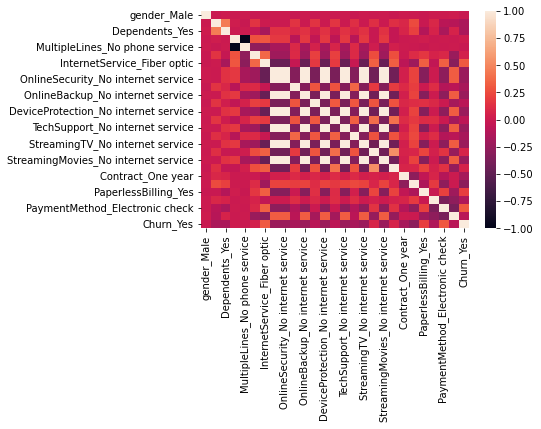

In [32]:
sns.heatmap(df_cat.corr(), fmt='.2f')

# Train prediction model
# Linear Model

In [33]:
def fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    The function does:
    1. Split your data into an X matrix and a response vector y
    2. Create training and test sets of data
    3. Instantiate a LinearRegression model with normalized data
    3. Fit your model to the training data
    4. Predict the response for the training data and the test data
    5. Obtain an rsquared value for both the training and test data
    '''
    
    X = df.drop(response_col, axis=1) #5 
    y = df[response_col]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = test_size, random_state=rand_state) #6
    lm_model = linear_model.LinearRegression(normalize=True) #7
    lm_model.fit(X_train, y_train) #8
    y_test_preds = lm_model.predict(X_test) #9
    y_train_preds = lm_model.predict(X_train)
    test_score = metrics.r2_score(y_test, y_test_preds) #10
    train_score = metrics.r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [34]:
test_score_cat_linear_mod, train_score_cat_linear_mod, lm_model_cat, X_train_cat, X_test_cat, y_train_cat, y_test_cat = fit_linear_mod(
    df_cat, 'Churn_Yes', obj_cols_lst, dummy_na=False, test_size=.2, rand_state=42)

C:\Users\kwojn\miniconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [35]:
print(f'Using only categorical data, we get a train r2 score of: \n{train_score_cat_linear_mod} \nand a test r2 score of: \n{test_score_cat_linear_mod}')

Using only categorical data, we get a train r2 score of: 
0.26124613166546506 
and a test r2 score of: 
0.22496096957716194


# Normalize - continuous variables

In [59]:
#Normalize a column
def normalize_cont_columns(df):
    df_num = df.select_dtypes(exclude=['object'])
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()

    for col in df_num:
        df_num[col] = min_max_scaler.fit_transform(df_num[[col]].values.astype(float))

    return df_num

df_num = normalize_cont_columns(df_clean)

In [38]:
# Recombine numeric and categorical variables
df_cat_and_num = pd.concat([df_cat, df_num], axis=1)
df_cat_and_num.head()

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0.0,0.000000,0.115423,0.001275
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0.0,0.464789,0.385075,0.215867
2,1,0,0,1,0,0,0,0,0,1,...,0,1,0,0,1,1,0.0,0.014085,0.354229,0.010310
3,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0.0,0.619718,0.239303,0.210241
4,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,1,0.0,0.014085,0.521891,0.015330


<AxesSubplot:>

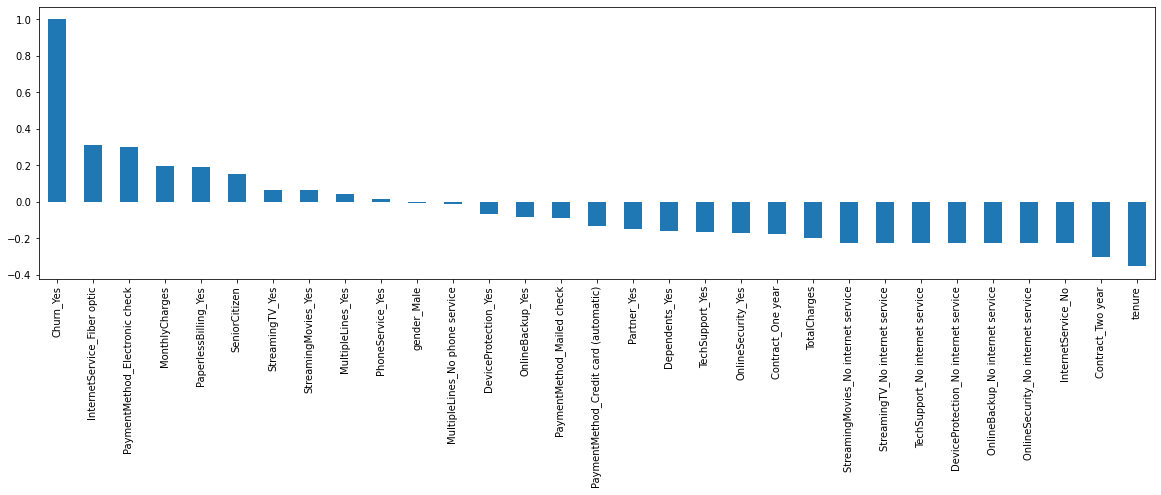

In [39]:
df_cat_and_num.corr()['Churn_Yes'].sort_values(ascending=False).plot(kind='bar', figsize=(20,5))

In [40]:
test_score_norm_linear_mod, train_score_norm_linear_mod, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(
    df_cat_and_num, 'Churn_Yes', obj_cols_lst, dummy_na=False, test_size=.2, rand_state=42)

C:\Users\kwojn\miniconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [41]:
print(f'Using both categorical & continuous data, we get a train r2 score of: \n{train_score_norm_linear_mod} vs {train_score_cat_linear_mod} \nand a test r2 score of: \n{test_score_norm_linear_mod} vs {test_score_cat_linear_mod}')

Using both categorical & continuous data, we get a train r2 score of: 
0.29126668497673835 vs 0.26124613166546506 
and a test r2 score of: 
0.25221391005796423 vs 0.22496096957716194


In [42]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df#.head(20)

,est_int,coefs,abs_coefs
16,StreamingTV_No internet service,-2.169414e+10,2.169414e+10
18,StreamingMovies_No internet service,-2.085796e+10,2.085796e+10
7,InternetService_No,1.251573e+10,1.251573e+10
14,TechSupport_No internet service,8.404049e+09,8.404049e+09
12,DeviceProtection_No internet service,8.112011e+09,8.112011e+09
10,OnlineBackup_No internet service,7.427129e+09,7.427129e+09
8,OnlineSecurity_No internet service,6.093182e+09,6.093182e+09
4,MultipleLines_No phone service,-2.781813e+08,2.781813e+08
3,PhoneService_Yes,-2.781813e+08,2.781813e+08
29,TotalCharges,-3.940495e-01,3.940495e-01


# Logistic regression

In [43]:
def feature_weights(X_df, classifier, classifier_name):
    weights = pd.Series(classifier.coef_[0], index=X_df.columns.values).sort_values(ascending=False)

    top_weights_selected = weights[:10]
    plt.figure(figsize=(7,6))
    plt.tick_params(labelsize=10)
    plt.title(f'{classifier_name} - Top 10 Features')
    top_weights_selected.plot(kind='bar')
    
    bottom_weights_selected = weights[-10:]
    plt.figure(figsize=(7,6))
    plt.tick_params(labelsize=10)
    plt.title(f'{classifier_name} - Bottom 10 Features')
    bottom_weights_selected.plot(kind='bar')

    return print("")

def confusion_matrix_plot(X_train, y_train, X_test, y_test, classifier, y_pred, classifier_name):
    fig, ax = plt.subplots(figsize=(7, 6))
    metrics.plot_confusion_matrix(classifier, X_test, y_test, display_labels=["No Churn", "Churn"], cmap=plt.cm.Blues, normalize=None, ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix')
    plt.show()

    fig, ax = plt.subplots(figsize=(7, 6))
    metrics.plot_confusion_matrix(classifier, X_test, y_test, display_labels=["No Churn", "Churn"], cmap=plt.cm.Blues, normalize='true', ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix (norm.)')
    plt.show()

    print(f'Accuracy score test: {metrics.accuracy_score(y_test, y_pred)}')
    print(f'Accuracy score train: {classifier.score(X_train, y_train)} (as comparison)')
    return print("")

def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):

    y_pred_prob = y_pred_probabilities[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'{classifier_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.show()

    return print(f'AUC Score (ROC): {metrics.roc_auc_score(y_test, y_pred_prob)}\n')

def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):
    y_pred_prob = y_pred_probabilities[:, 1]
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)

    plt.plot(recall, precision, label=f'{classifier_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier_name} - Precision-Recall Curve')
    plt.show()

    f1_score_result, auc_score_result = metrics.f1_score(y_test, y_pred), metrics.auc(recall, precision)

    return print(f'f1 Score: {f1_score_result} \n AUC Score (PR): {auc_score_result}\n')
    

In [44]:
def fit_logreg_mod(df, response_col, test_size, rand_state=42):
    '''   
    The function does:
    1. Split your data into an X matrix and a response vector y
    2. Create training and test sets of data
    3. Instantiate a LogisticRegression model with normalized data
    4. Fit your model to the training data
    5. Predict the response for the training data and the test data
    6. Obtain an rsquared value for both the training and test data
    '''
    
    X = df.drop(response_col, axis=1) #1
    y = df[response_col]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = test_size, random_state=rand_state) #2
    lm_model = linear_model.LogisticRegression(random_state=rand_state, max_iter = 100) #3
    lm_model.fit(X_train, y_train) #4
    y_test_preds = lm_model.predict(X_test) #5
    y_train_preds = lm_model.predict(X_train)
    test_score = metrics.r2_score(y_test, y_test_preds) #6
    train_score = metrics.r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [45]:
test_score_logreg_mod, train_score_logreg_mod, lm_model_logreg, X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = fit_logreg_mod(
    df_cat_and_num, 'Churn_Yes', .2, 42)

In [46]:
print(f'Using linear model we get a train r2 score of: \n{train_score_norm_linear_mod} vs logistic regression model {train_score_logreg_mod} \nand a test r2 score of: \n{test_score_norm_linear_mod} vs {test_score_logreg_mod}')

Using linear model we get a train r2 score of: 
0.29126668497673835 vs logistic regression model 0.014268708447042977 
and a test r2 score of: 
0.25221391005796423 vs -0.08527159873894097


In [47]:
y_pred_logreg = lm_model_logreg.predict(X_test)
y_pred_logreg_prob = lm_model_logreg.predict_proba(X_test)

C:\Users\kwojn\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


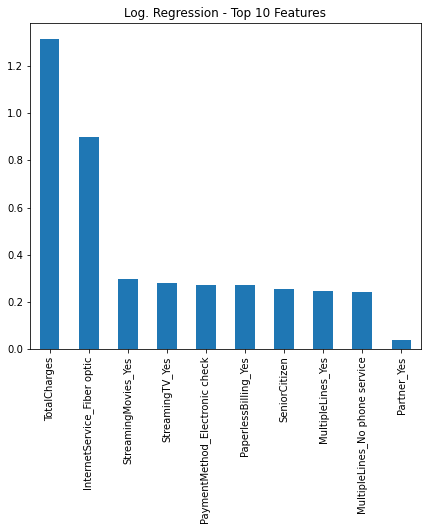

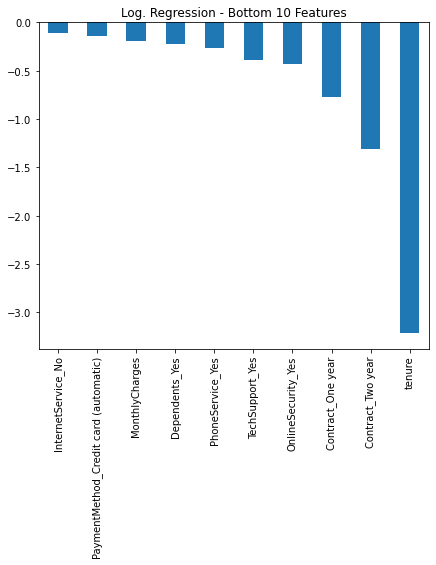

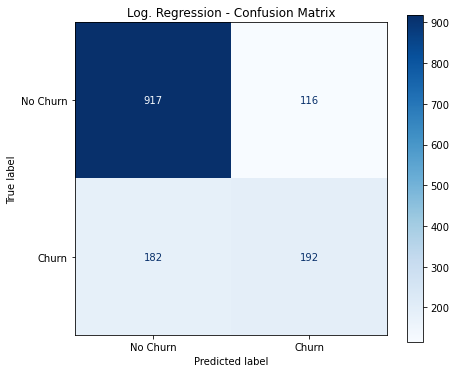

C:\Users\kwojn\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


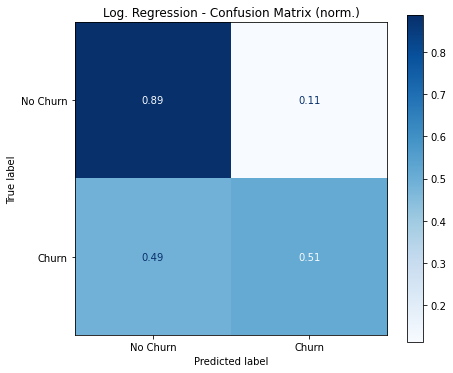

Accuracy score test: 0.7882018479033405
Accuracy score train: 0.8076444444444445 (as comparison)



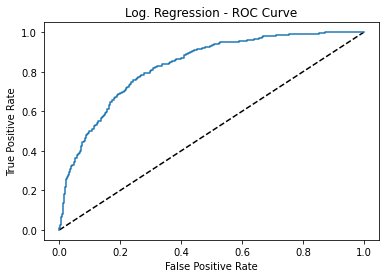

AUC Score (ROC): 0.8316750443907213



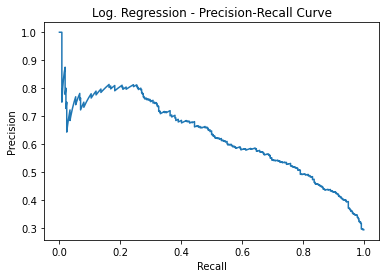

f1 Score: 0.5630498533724341 
 AUC Score (PR): 0.6275875549096759



In [48]:
X1 = df_cat_and_num.drop('Churn_Yes', axis=1)

feature_weights(X1, lm_model_logreg, 'Log. Regression')
confusion_matrix_plot(X_train_logreg, y_train_logreg, X_test_logreg, y_test_logreg, lm_model_logreg, y_pred_logreg, 'Log. Regression')
roc_curve_auc_score(X_test_logreg, y_test_logreg, y_pred_logreg_prob, 'Log. Regression')
precision_recall_curve_and_scores(X_test_logreg, y_test_logreg, y_pred_logreg, y_pred_logreg_prob, 'Log. Regression')